## Imports and installs

In [1]:
#for ml
import os
import torch

#for audio
import librosa
import torchaudio


os.environ['KERAS_BACKEND']='torch'

import keras

inhai


## Create dataset

In [2]:
import pandas as pd
data = pd.read_csv('..\\data\\cv_rough.csv')

In [10]:
data.speaker[0]

'28a0e5ec608af5cd213913d7983eff7c8a8f4dad4c47f62fc8ca0e3745eec8be99c1a7433d49b4518fb2263d559030b939dd6799e177958164ef94ee73bf5e93'

In [4]:
labeldict = {index: element for index, element in enumerate(data['speaker'].unique())}

def id2label(vec):
    for i in range(len(labeldict)):
        if labeldict[i]==vec:
            if os.environ['KERAS_BACKEND']=='torch':
                return torch.Tensor([i])            
            else:
                return tf.convert_to_tensor([i])


In [5]:
#using pytorch Dataset and Dataloader

from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self,path,label):
        self.path = path
        self.label = label
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,index):
        audio_path = self.path[index]
        speech,sample_rate = librosa.load(audio_path)
        resampler = torchaudio.transforms.Resample(orig_freq = sample_rate)
        speech = resampler.forward(torch.Tensor(speech))
        sample_rate = 16000
        label = id2label(self.label[index])

        return audio_path,speech,sample_rate,label


In [6]:
BATCH_SIZE = 4

In [7]:
#split train and test

import numpy as np


percent = 0.8

shuffled_indices = np.random.permutation(len(data))

split = int(percent*len(data))

print(split)

train_indices = shuffled_indices[:split]
val_indices = shuffled_indices[split:]

data_train = data.iloc[train_indices].reset_index(drop=True)
data_val = data.iloc[val_indices].reset_index(drop=True)


train_dataset = AudioDataset(data_train['path'],data_train['speaker'])
val_dataset = AudioDataset(data_val['path'],data_val['speaker'])

2715


In [20]:
transform(torch.Tensor(dummy_audio)).shape

torch.Size([128, 472])

In [14]:
from torch.nn.functional import pad

transform = torchaudio.transforms.MelSpectrogram(n_fft=512)

def collate_fn(batch):
    #print(batch)
    path, waveforms, sample_rates, label = zip(*batch)
    # Calculate the maximum length within this batch
    max_length = max(len(waveform) for waveform in waveforms)
    #print(f'max_length = {max_length}')
    # Pad all sequences to match the maximum length
    padded_waveforms = torch.stack(
        [torch.transpose(
            transform(
                pad(
                    waveform,(0, max_length - len(waveform)), mode='constant', value=0)),0,1) for waveform in waveforms])
    
    #fft
    padded_waveforms = torch.unsqueeze(padded_waveforms,-1)
    
    #print(f'length of the largest audio: {len(padded_waveforms[0])}')
    
    return padded_waveforms,torch.stack(label)



In [15]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


for batch_idx, (audio_batch, label_batch) in enumerate(train_dataloader):
    print(f"Batch #{batch_idx}")
    print(f"\tAudio batch:\n{audio_batch.shape}\n")
    print(f"\tLabel batch:\n{label_batch}\n")
    break

Batch #0
	Audio batch:
torch.Size([4, 417, 128, 1])

	Label batch:
tensor([[ 3.],
        [54.],
        [72.],
        [85.]])



## Create model

In [21]:

inputs = keras.Input(shape=(None,128,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x) 
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) 
x = keras.layers.MaxPooling2D(pool_size=2)(x) 
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x) 
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) 
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(len(labeldict),'softmax')(x)

model_mfcc = keras.Model(inputs=inputs,outputs=outputs)

model_mfcc.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, None, 126, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, None, 63, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, None, 61, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, None, 30, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, None, 28, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, None, 14, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, None, 12, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,540 (1.58 MB)

 Trainable params: 413,540 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_mfcc.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = model_mfcc.fit(train_dataloader,
                     validation_data=val_dataloader,
                     epochs=10,
                     batch_size=BATCH_SIZE)

Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 343s 506ms/step - accuracy: 0.2734 - loss: 3.3996 - val_accuracy: 0.4580 - val_loss: 2.7510
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 274s 403ms/step - accuracy: 0.4040 - loss: 2.5913 - val_accuracy: 0.4816 - val_loss: 2.4620
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 274s 404ms/step - accuracy: 0.5001 - loss: 2.1752 - val_accuracy: 0.5287 - val_loss: 2.4727
Epoch 4/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 278s 409ms/step - accuracy: 0.5557 - loss: 1.9258 - val_accuracy: 0.6289 - val_loss: 1.7224
Epoch 5/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 310s 457ms/step - accuracy: 0.6357 - loss: 1.5433 - val_accuracy: 0.6524 - val_loss: 1.7225
Epoch 6/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 336s 495ms/step - accuracy: 0.6750 - loss: 1.3839 - val_accuracy: 0.7158 - val_loss: 1.3565
Epoch 7/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 364s 536ms/step - accuracy: 0.7423 - loss: 1.1894 - val_accuracy: 0.7261 - val_loss: 1.3045
Epoch 8/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 476s 701ms/step - accuracy: 0.7662 -

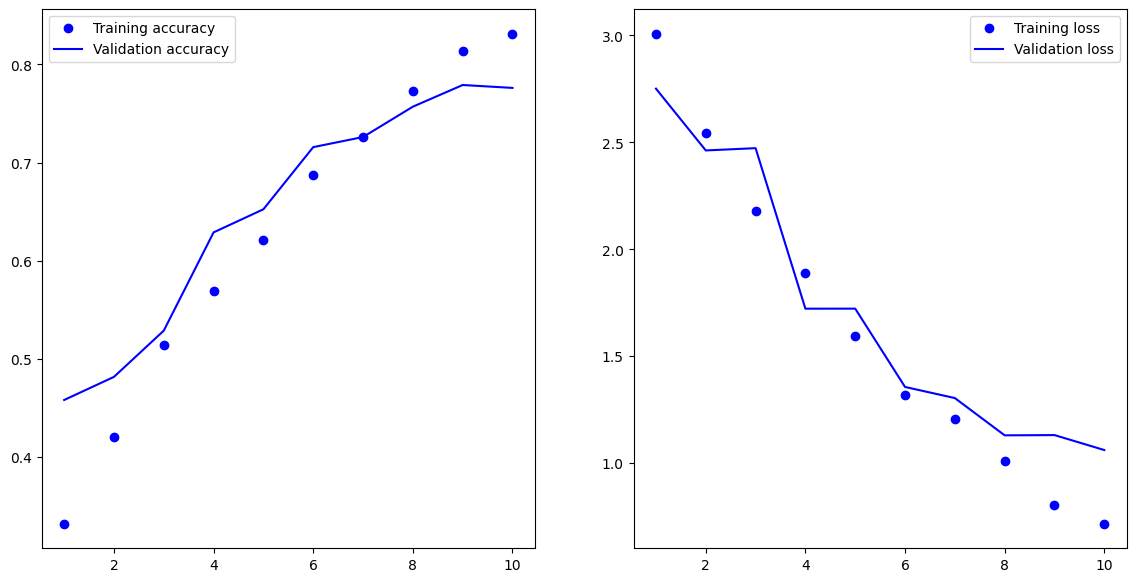

In [24]:
import matplotlib.pyplot as plt 
accuracy = history.history["accuracy"] 
val_accuracy = history.history["val_accuracy"] 
loss = history.history["loss"] 
val_loss = history.history["val_loss"] 

epochs = range(1, len(accuracy) + 1) 

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.legend()

plt.savefig('..\\mfcc_history.png')

## Save model

In [25]:
model_mfcc.save('..\\models\\model_mfcc.keras')

In [26]:
testmodel = keras.saving.load_model('..\\models\\model_mfcc.keras', custom_objects=None, compile=True, safe_mode=True)

testmodel.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, None, 126, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, None, 63, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, None, 61, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, None, 30, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, None, 28, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, None, 14, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, None, 12, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,240,622 (4.73 MB)

 Trainable params: 413,540 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 827,082 (3.16 MB)

In [27]:
testmodel.evaluate(val_dataloader)

170/170 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - accuracy: 0.7675 - loss: 1.0754


[1.0629900693893433, 0.7790868878364563]